<a href="https://colab.research.google.com/github/Sirabhop/Preclinical-AD-EEG-classification/blob/master/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from oauth2client.service_account import ServiceAccountCredentials
from sklearn import preprocessing

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#os.chdir("/content/drive/My Drive/Colab Notebooks")
#%run EEG_Feature_Extraction.ipynb

os.chdir("/content/drive/My Drive/EEG Data")

In [0]:
#Set up google drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scope)
client = gspread.authorize(creds)

# **Descriptive Statistics**

##**Demographics**

In [0]:
dict = {'sex': ['male', 'female', 'female', 'female', 'female', 'female', 'female', 'female'],
        'ages':[63, 60, 66, 68, 72, 74, 61, 64],
        'group': [0,1,1,0,1,1,0,0]} #0 = Risk Free, 1 = At risk

In [5]:
df = pd.DataFrame(data = dict)
df

,sex,ages,group
0,male,63,0
1,female,60,1
2,female,66,1
3,female,68,0
4,female,72,1
5,female,74,1
6,female,61,0
7,female,64,0


##**Cognitive Markers**


In [0]:
gsheet_MoCA = client.open("MoCA DATA").sheet1
gsheet_FCSRT = client.open("FCSRT DATA").sheet1
list_MoCA = gsheet_MoCA.get_all_records()
list_FCSRT = gsheet_FCSRT.get_all_records()

In [0]:
FCSRT = pd.DataFrame(list_FCSRT)
MoCA = pd.DataFrame(list_MoCA)

MoCA = pd.concat([df, MoCA], axis = 1).drop(['NAME','SEX','AGE'], axis = 1)
CogMarkers = pd.concat([df, FCSRT, MoCA[['SUM']]], axis = 1)
CogMarkers['group'] = CogMarkers['group'].astype('category')
CogMarkers.set_index('id', inplace = True)
CogMarkers.rename(columns = {'SUM':'MoCA'}, inplace = True)

CogMarkers['IR-TotalR'] = CogMarkers['IR-FreeR']+CogMarkers['IR-CuedR']
CogMarkers['DL-TotalR'] = CogMarkers['DL-FreeR']+CogMarkers['DL-CuedR']
#CogMarkers.to_csv('cognitive markers.csv')

###**FCSRT**

* **% Encoded**
  * SOMI 0: > 95.8%
  * SOMI 1: > 95.8%
  * SOMI 2a: > 95.8%
  * SOMI 2b: > 93.75 and < 95.8%
  * SOMI 4: > 68.78 and < 91.67%



In [0]:
#computed from [Total Recall x 100]/16
CogMarkers['%Encoded'] = ((CogMarkers['IR-FreeR']+CogMarkers['IR-CuedR'])*100)/16 

*   **% Retrieval**
  * SOMI 0: > 62.5%
  * SOMI 1: > 52.1% and < 62.5%
  * SOMI 2a: > 41.6% and < 50%
  * SOMI 2b: > 41.6% and < 50%
  * SOMI 4: Any


In [0]:
CogMarkers['%Retrieval'] =  CogMarkers['IR-FreeR']*100/16

*   **Classify SS according to SOMI model criteria**


In [0]:
for i in range(-1,7):
  if (CogMarkers.iloc[i, 8] > 95.8) & (CogMarkers.iloc[i, 9] > 62.5):
    CogMarkers['SOMI stage'] = 'SOMI 0'

  if (CogMarkers.iloc[i, 8] > 95.8):
    if (CogMarkers.iloc[i, 9] > 52.1) & (CogMarkers.iloc[i, 9] < 62.5):
      CogMarkers['SOMI stage'] = 'SOMI 1'

  if (CogMarkers.iloc[i, 8] > 95.8):
    if (CogMarkers.iloc[i, 9] > 41.6) & (CogMarkers.iloc[i, 9] < 50):
      CogMarkers['SOMI stage'] = 'SOMI 2a'

  if (CogMarkers.iloc[i, 8] > 93.75) & (CogMarkers.iloc[i, 8] < 95.8):
    if (CogMarkers.iloc[i, 9] > 41.6) & (CogMarkers.iloc[i, 9] < 50):
      CogMarkers['SOMI stage'] = 'SOMI 2b'

  if (CogMarkers.iloc[i, 8] > 68.78) & (CogMarkers.iloc[i, 8] < 91.67):
    if CogMarkers.iloc[i, 9] <= 41.6:
      CogMarkers['SOMI stage'] = 'SOMI 4'
  else:
    CogMarkers['SOMI stage'] = 'NaN'

In [0]:
Cog_Normal = CogMarkers[CogMarkers['group'] == 0]
Cog_Risk = CogMarkers[CogMarkers['group'] == 1]

In [0]:
per_cog_risk = Cog_Risk.copy()
per_cog_normal = Cog_Normal.copy()

In [0]:
per_cog_risk['IR-FreeR'] = (Cog_Risk['IR-FreeR']*100)/16
per_cog_risk['IR-CuedR'] = (Cog_Risk['IR-CuedR']*100)/(16-Cog_Risk['IR-FreeR'])
per_cog_risk['DL-FreeR'] = (Cog_Risk['DL-FreeR']*100)/16
per_cog_risk['DL-CuedR'] = (Cog_Risk['DL-CuedR']*100)/(16-Cog_Risk['DL-FreeR'])

per_cog_normal['IR-FreeR'] = (Cog_Normal['IR-FreeR']*100)/16
per_cog_normal['IR-CuedR'] = (Cog_Normal['IR-CuedR']*100)/(16-Cog_Normal['IR-FreeR'])
per_cog_normal['DL-FreeR'] = (Cog_Normal['DL-FreeR']*100)/16
per_cog_normal['DL-CuedR'] = (Cog_Normal['DL-CuedR']*100)/(16-Cog_Normal['DL-FreeR'])



*   **Graph**



In [0]:
def create_plot_df(Normal, Risk):
  plot_risk = Risk.drop(['sex', 'ages', 'group', 'MoCA', '%Encoded', '%Retrieval',	'SOMI stage'], axis =1)
  plot_risk = plot_risk.transpose()
  plot_risk = plot_risk.reset_index()
  plot_risk['mean'] = plot_risk.mean(axis = 1)

  plot_normal = Normal.drop(['sex', 'ages', 'group', 'MoCA', '%Encoded', '%Retrieval',	'SOMI stage'], axis =1)
  plot_normal = plot_normal.transpose()
  plot_normal = plot_normal.reset_index()
  plot_normal['mean'] = plot_normal.mean(axis = 1)

  return plot_normal, plot_risk

In [0]:
def plot_markers(plot_data, xlab, ylab, title):
  columns_risk = plot_data.drop(['index', 'mean'], axis = 1)
  title = title

  fig, ax = plt.subplots()
  for subjects in columns_risk:
      ax.plot(plot_data['index'], plot_data[subjects])
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')

  return ax.plot()

In [0]:
def plot_mean_markers(plot_normal, plot_risk, xlab, ylab, title):
  title = title

  fig, ax = plt.subplots()
  ax.plot(plot_risk['index'], plot_risk['mean'], label = 'Risk group', color = 'red')
  ax.plot(plot_normal['index'], plot_normal['mean'], label = 'Normal group', color = 'green')
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.legend()
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')
  return ax.plot()

[]

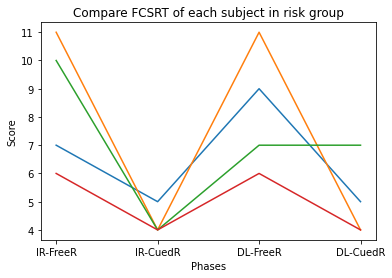

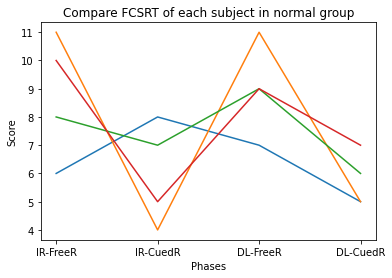

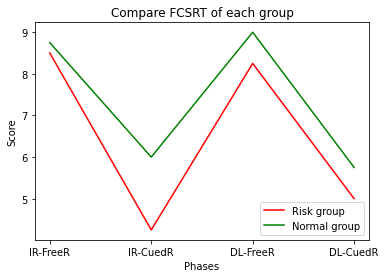

In [0]:
plot_cog_normal, plot_cog_risk = create_plot_df(Cog_Normal, Cog_Risk)
plot_markers(plot_cog_risk, 'Phases', 'Score', 'Compare FCSRT of each subject in risk group')
plot_markers(plot_cog_normal, 'Phases', 'Score', 'Compare FCSRT of each subject in normal group')
plot_mean_markers(plot_cog_normal, plot_cog_risk, 'Phases', 'Score', 'Compare FCSRT of each group')

[]

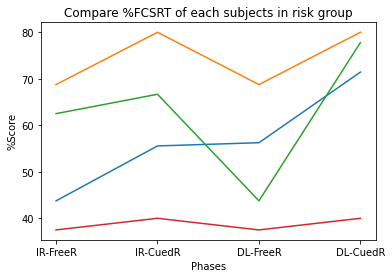

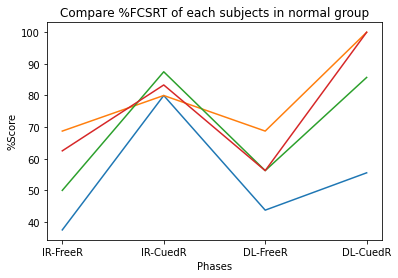

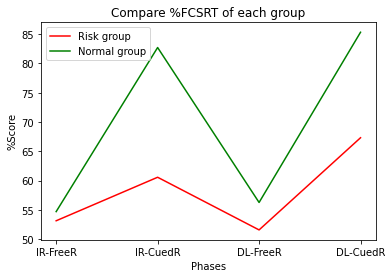

In [0]:
plot_cog_normal, plot_cog_risk = create_plot_df(per_cog_normal, per_cog_risk)
plot_markers(plot_cog_risk, 'Phases', '%Score', 'Compare %FCSRT of each subjects in risk group')
plot_markers(plot_cog_normal, 'Phases', '%Score', 'Compare %FCSRT of each subjects in normal group')
plot_mean_markers(plot_cog_normal, plot_cog_risk, 'Phases', '%Score', 'Compare %FCSRT of each group')

### **MoCA**



In [0]:
MoCA_RiskFree = MoCA[MoCA['group'] == 0]
MoCA_Risk = MoCA[MoCA['group'] == 1]

##**Biomarkers**

In [0]:
features = pd.read_csv('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/RESEARCH DATA/EEG_features.csv')
features.drop(['Unnamed: 0', 'id'], inplace = True, axis = 1)
id_group = {'id':['SS2','SS4','SS5','SS6','SS7','SS8'],
            'group':[1,0,1,1,0,0]}
id_group = pd.DataFrame(id_group)
Biomarkers = pd.concat([id_group, features], axis = 1)
Biomarkers.set_index('id', inplace = True)

scaler = preprocessing.MinMaxScaler()
Biomarkers.iloc[:, 1:22] = scaler.fit_transform(Biomarkers.iloc[:, 1:22])

###**1) PSD**

In [0]:
#Import data from ggdrive
IR_psd_normal = pd.read_csv('IR_psd_normal.csv')
IR_psd_risk = pd.read_csv('IR_psd_risk.csv')

DL_psd_normal = pd.read_csv('DL_psd_normal.csv')
DL_psd_risk = pd.read_csv('DL_psd_risk.csv')

####**PSD of 32 electrodes**

In [0]:
def get_plot_df(normal, risk):
  #Import data
  psd_normal = normal.drop(['Unnamed: 0','O1', 'AF3','Fz', 'Fp1', 'Fp2', 'Oz'], axis = 1) #PO3, O1
  #psd_normal = normal[['Fz','Fp1','Fp2']].copy()
  psd_normal['bands'] = ['delta', 'theta', 'alpha', 'beta', 'gamma']
  psd_normal.set_index('bands', inplace = True)

  psd_risk = risk.drop(['Unnamed: 0', 'O1', 'AF3','Fz', 'Fp1', 'Fp2', 'Oz'], axis = 1) #Fp1, AF3, Fp2, Fz
  #psd_risk = risk[['Fz','Fp1','Fp2']].copy()
  psd_risk['bands'] = ['delta', 'theta', 'alpha', 'beta', 'gamma']
  psd_risk.set_index('bands', inplace = True)

  #Transpose
  plot_normal = psd_normal.transpose().reset_index()
  plot_risk = psd_risk.transpose().reset_index()

  #Delete index
  index = plot_normal['index']
  plot_normal.drop(['index'], inplace = True, axis = 1)
  plot_risk.drop(['index'], inplace = True, axis = 1)

  #Scaling by freq band
  scaler_n = preprocessing.MinMaxScaler()
  plot_normal[plot_normal.columns] = scaler_n.fit_transform(plot_normal[plot_normal.columns])

  scaler_r = preprocessing.MinMaxScaler()
  plot_risk[plot_risk.columns] = scaler_r.fit_transform(plot_risk[plot_risk.columns])

  #Prepare dataset 
  plot_normal = pd.concat((index, plot_normal), axis = 1)
  plot_risk = pd.concat((index, plot_risk), axis = 1)
  
  return plot_normal, plot_risk

In [0]:
IR_plot_normal, IR_plot_risk = get_plot_df(IR_psd_normal, IR_psd_risk)
DL_plot_normal, DL_plot_risk = get_plot_df(DL_psd_normal, DL_psd_risk)

In [0]:
#Plot
def plot_compare_psd(plot_normal, plot_risk, title):
  title = title
  bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
  fig = plt.figure(figsize=(40,20))
  for i in range(len(bands)):
      fig.add_subplot(3, 2, i+1)
      plt.plot(plot_risk['index'], plot_risk.iloc[:,i+1], label = 'Risk group', color = 'red')
      plt.plot(plot_normal['index'], plot_normal.iloc[:,i+1], label = 'Normal group', color = 'green')
      plt.title(plot_normal.columns[i+1]+' band')
      plt.xlabel('Channel')
      plt.ylabel('PSD (db)')
      plt.legend()
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/Biomarkers/'+title+'.png')
  return plt.show()

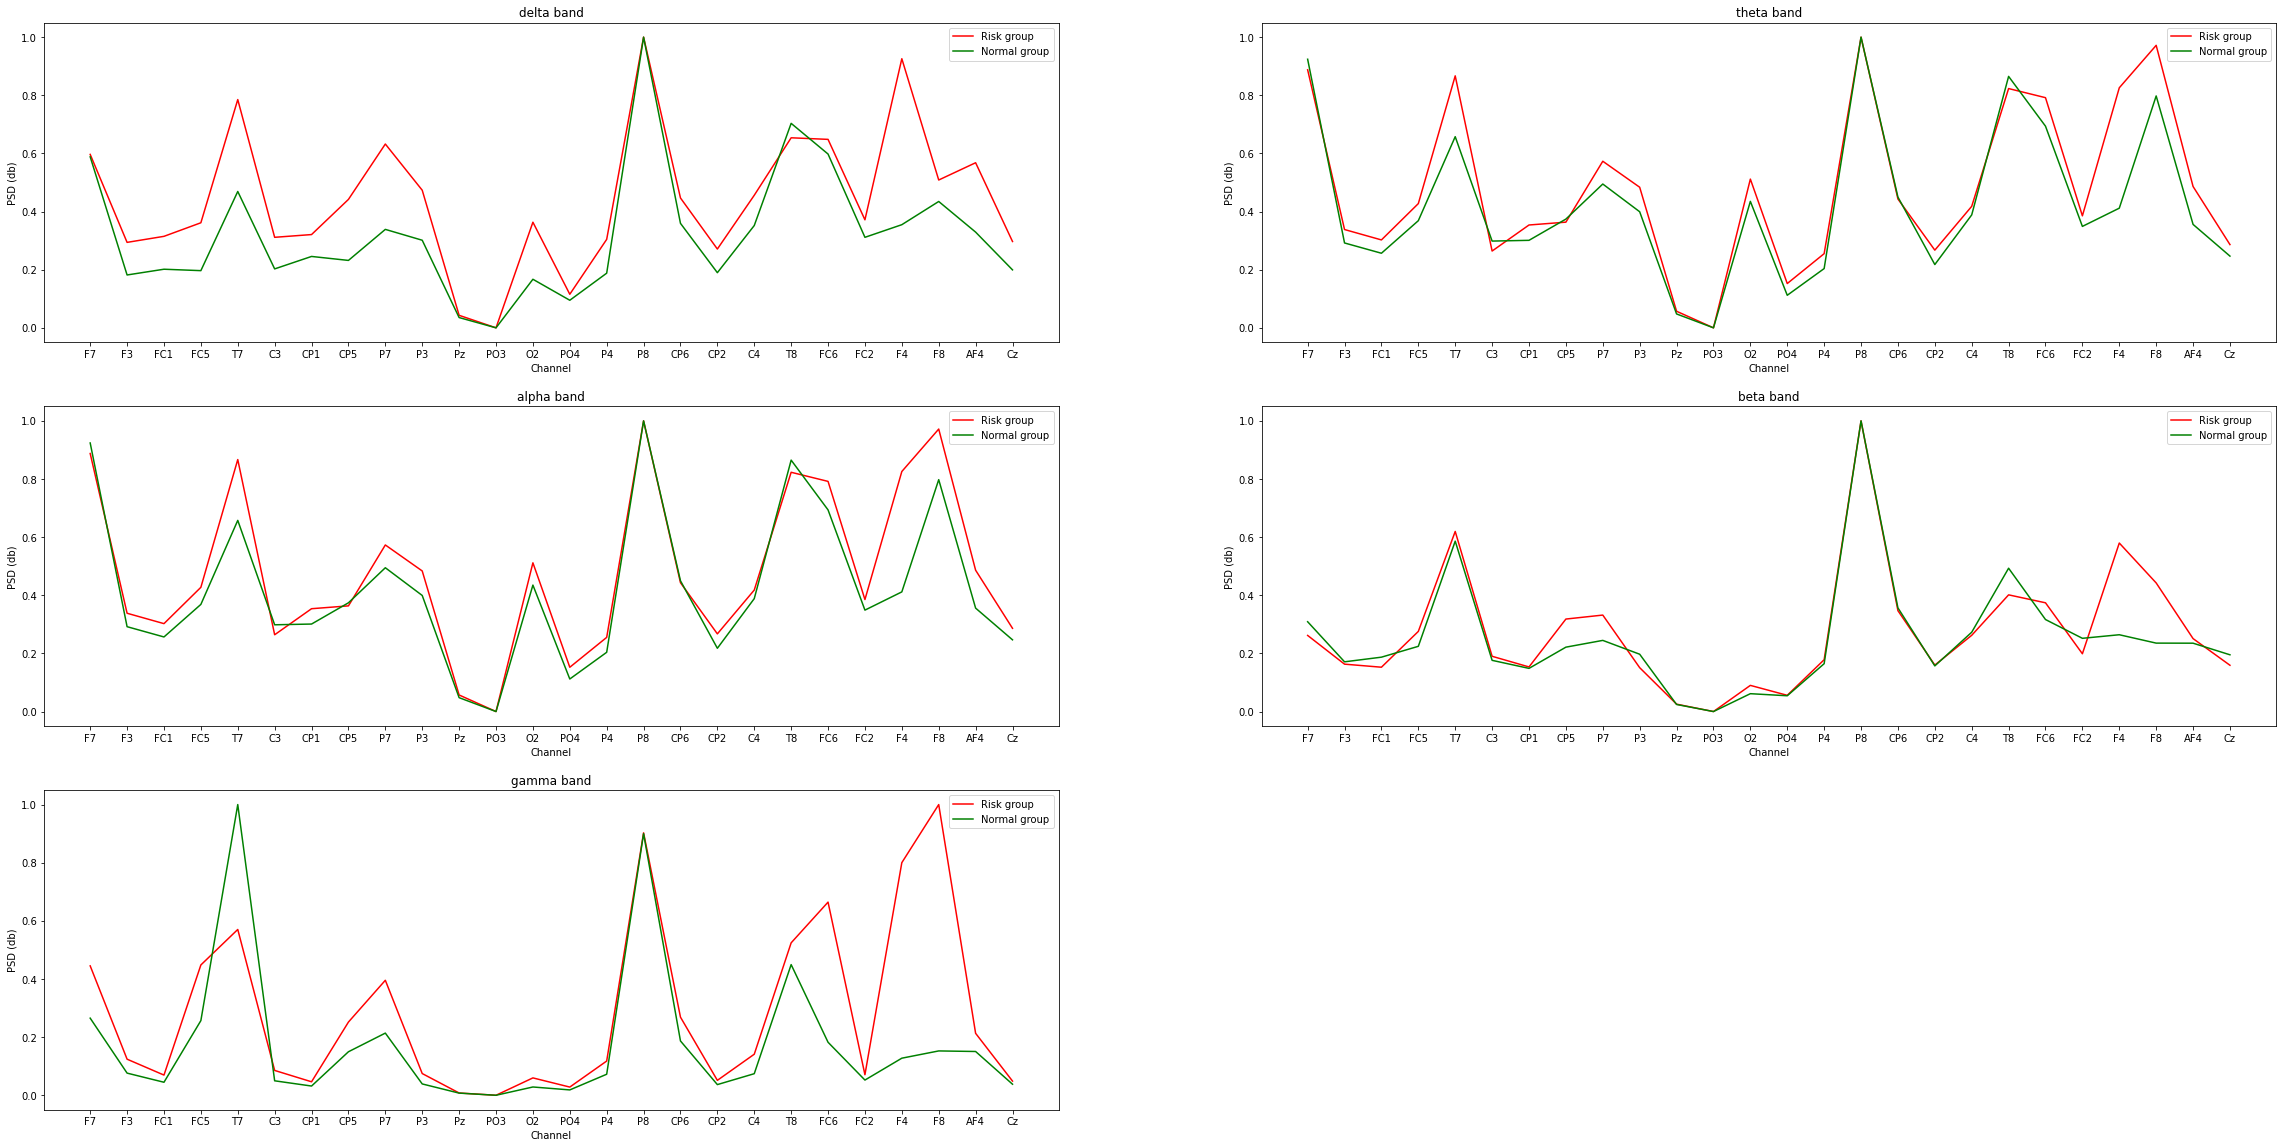

In [0]:
plot_compare_psd(IR_plot_normal, IR_plot_risk, 'compare PSD IR')

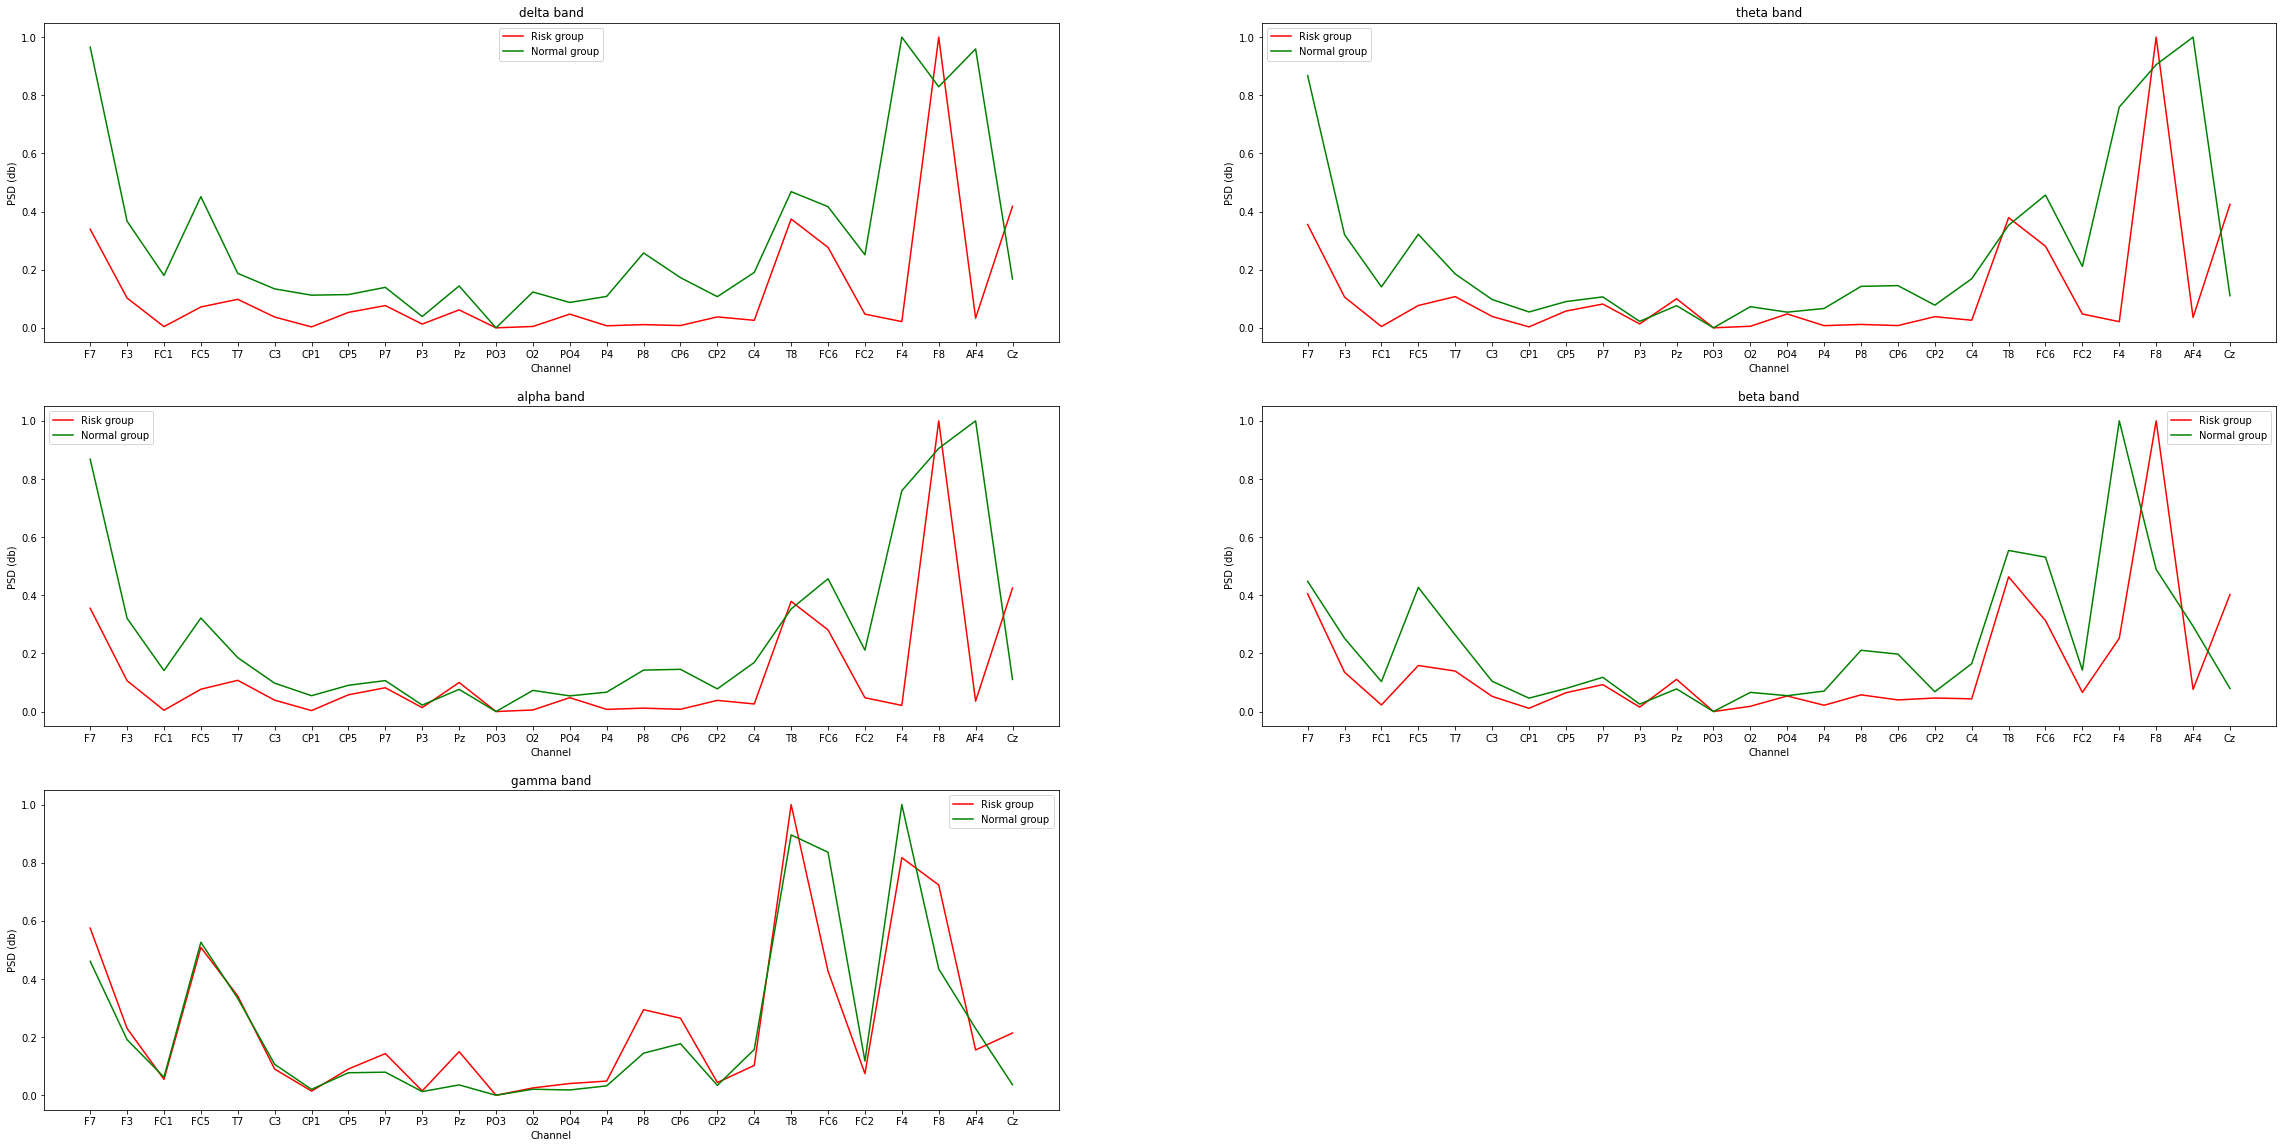

In [0]:
plot_compare_psd(DL_plot_normal, DL_plot_risk, 'compare PSD DL')

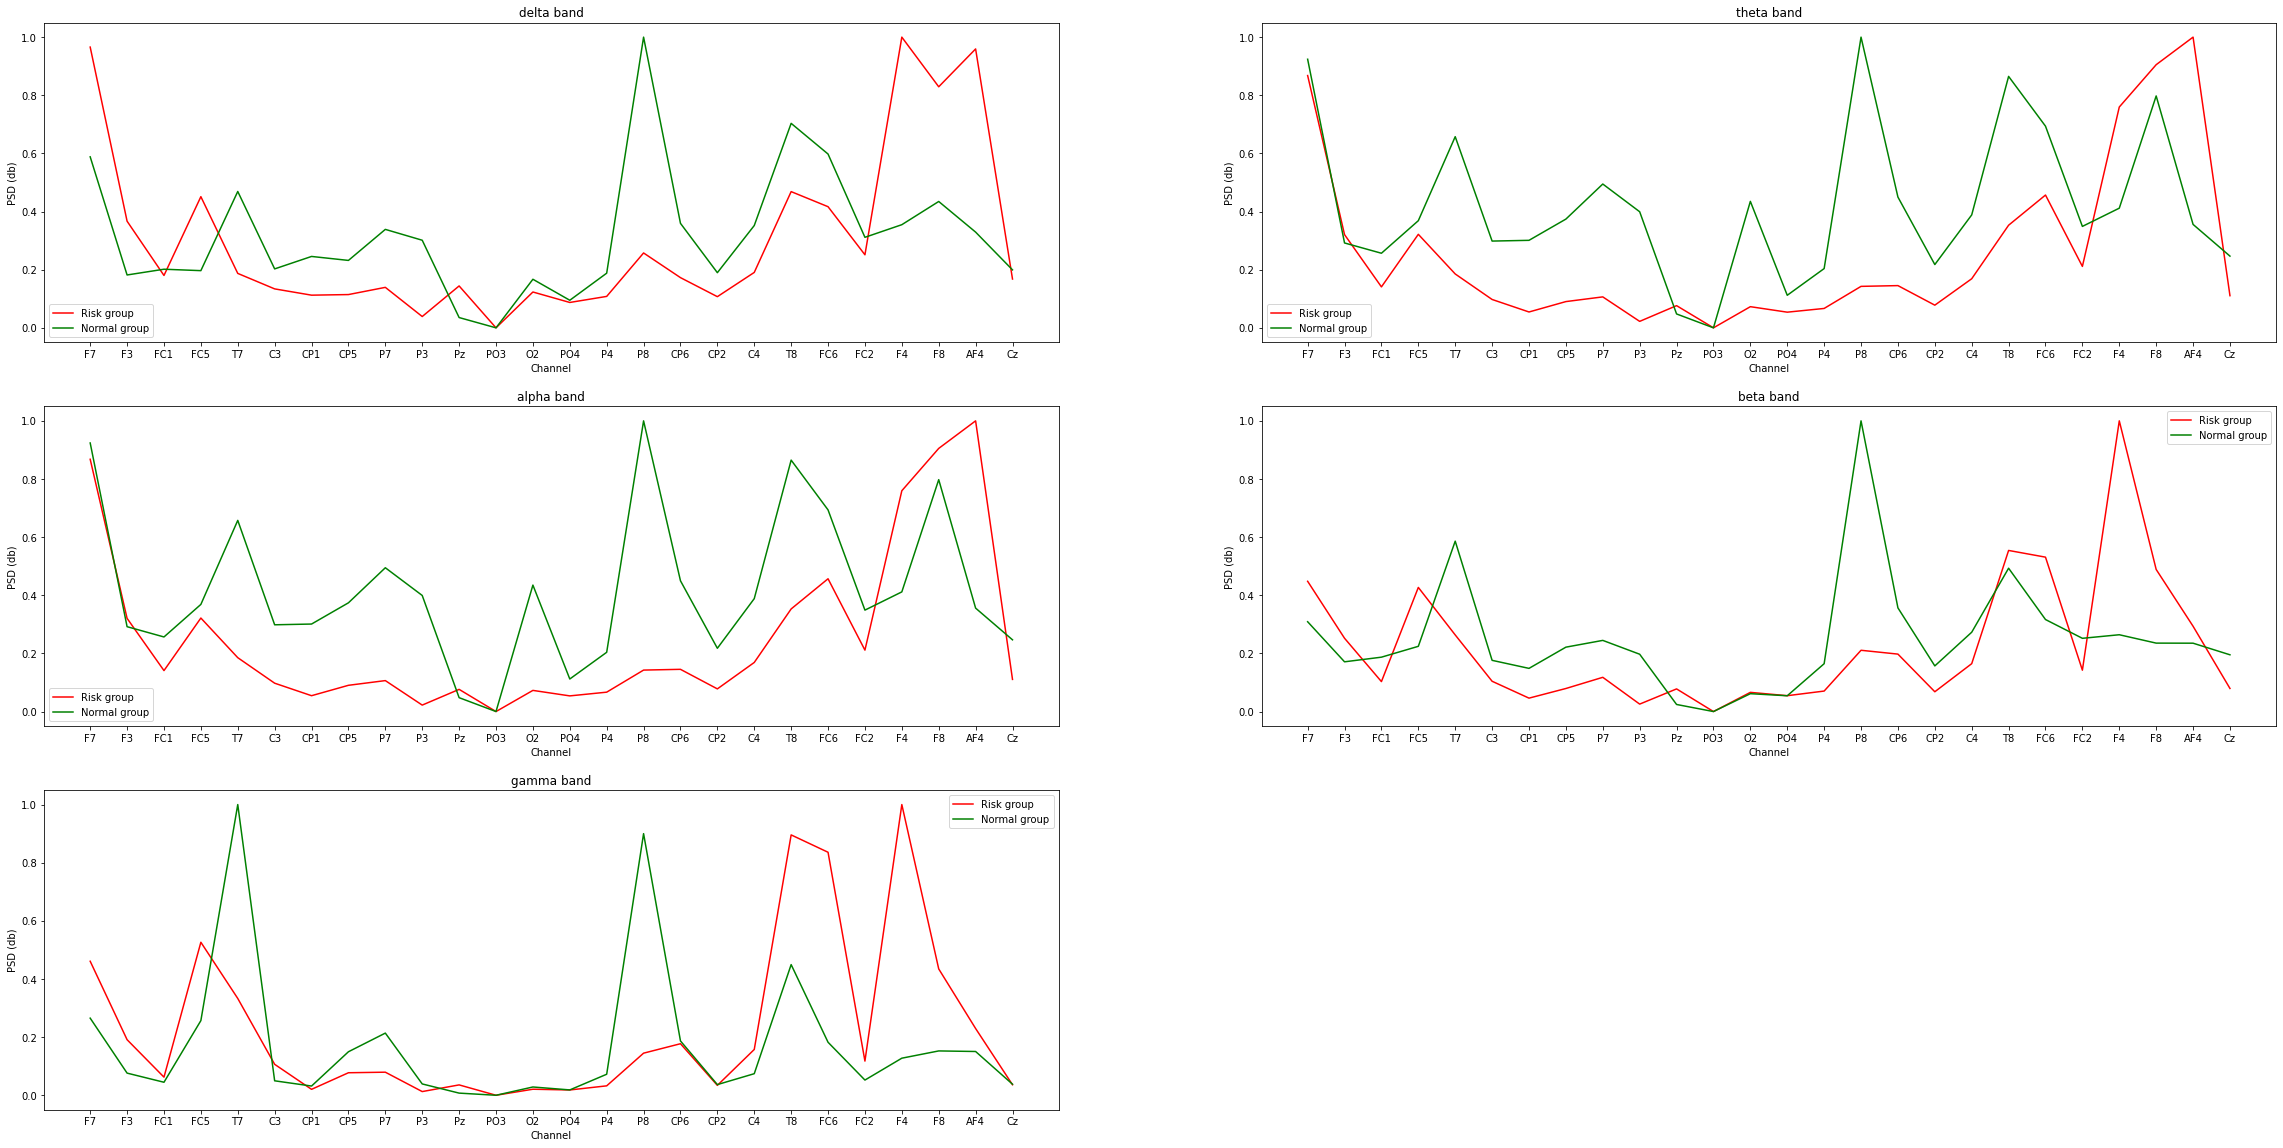

In [0]:
plot_compare_psd(IR_plot_normal, DL_plot_normal, 'compare IR and DL')

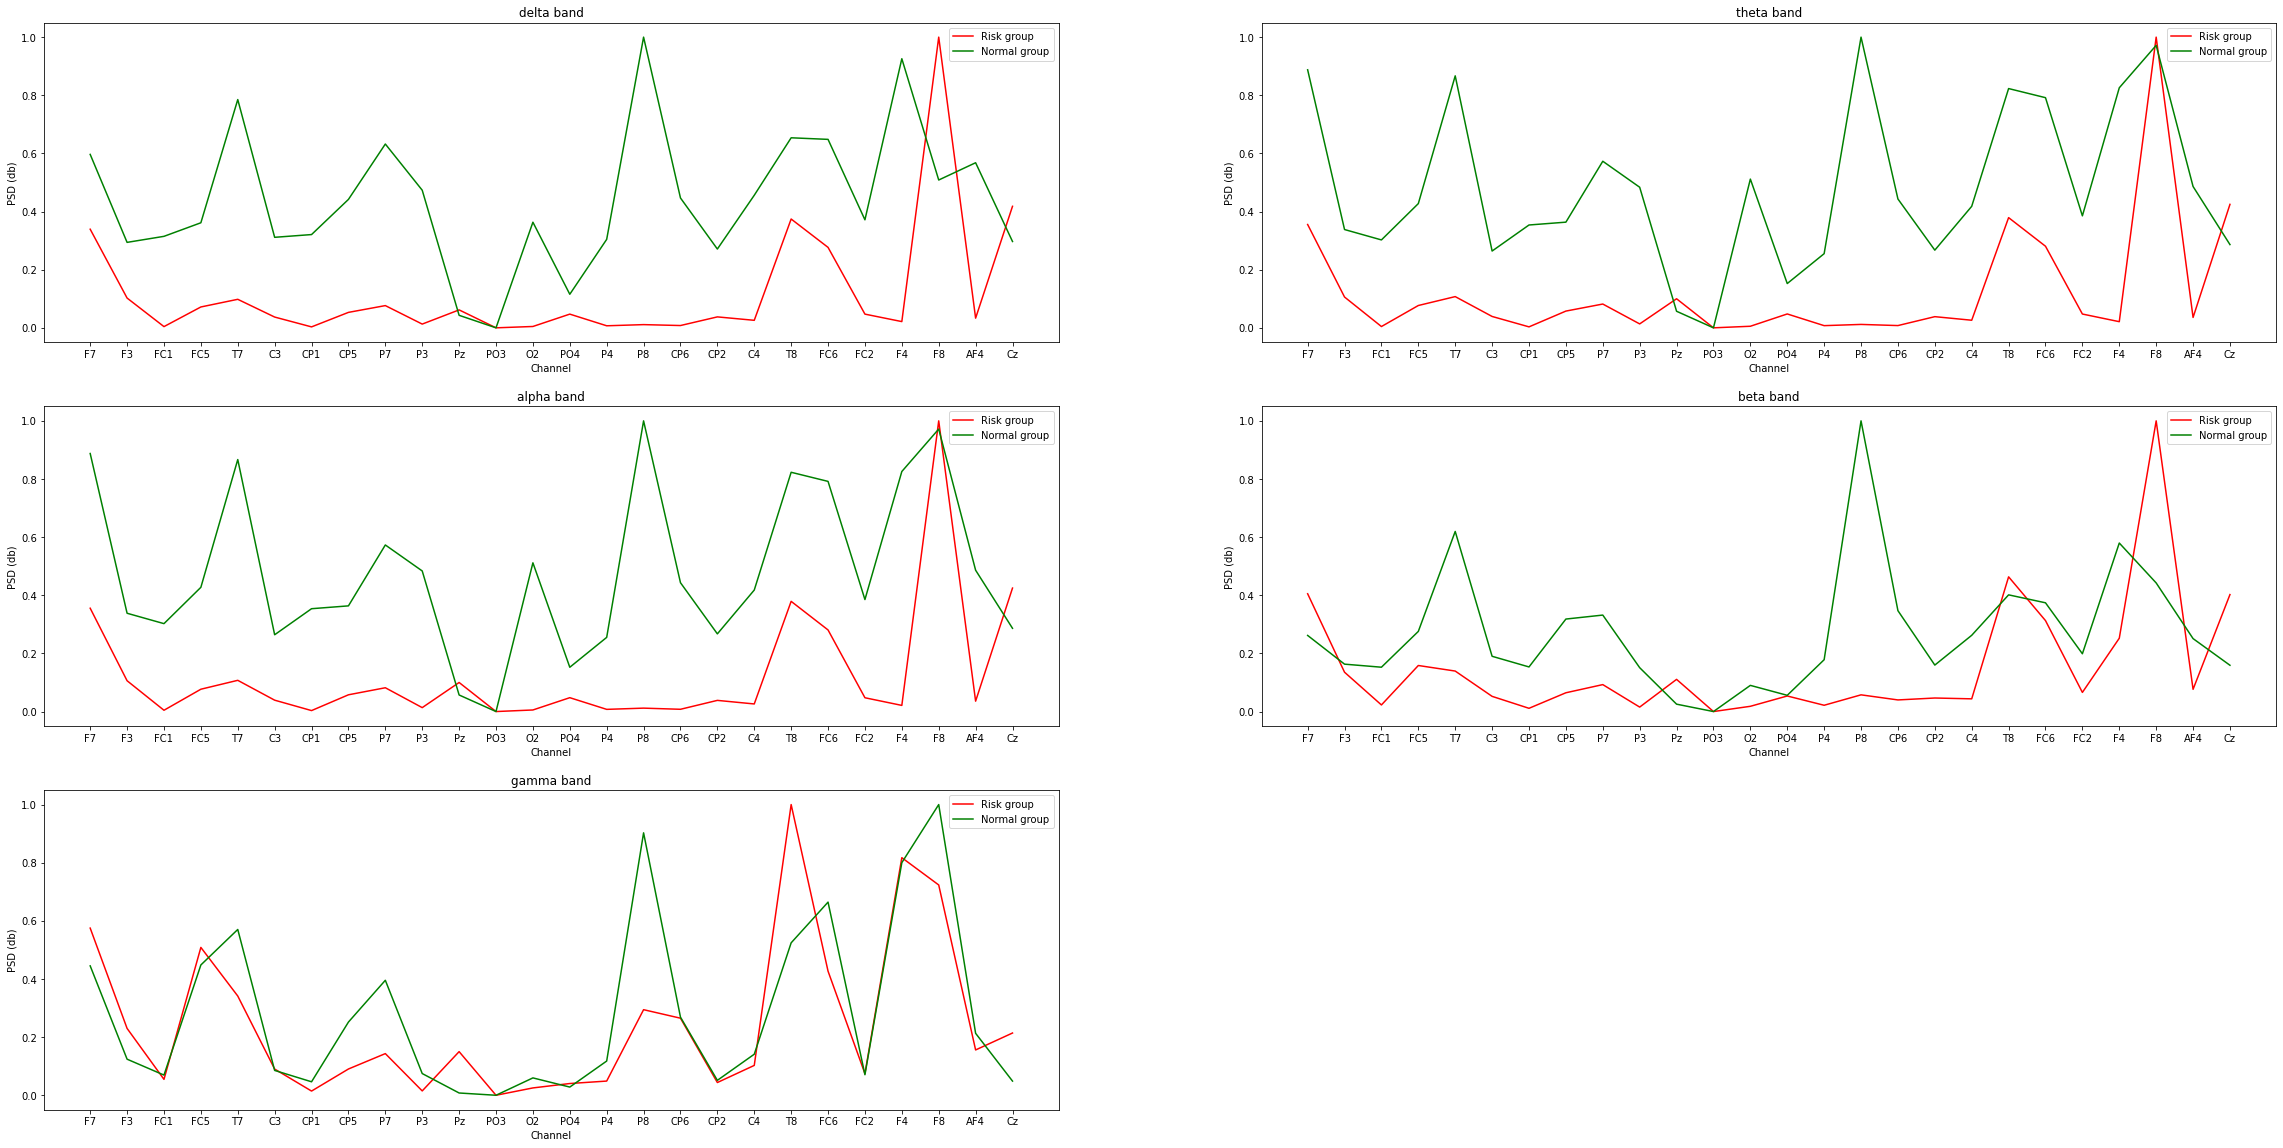

In [0]:
plot_compare_psd(IR_plot_risk, DL_plot_risk, 'compare PSD of risk group')

####**Plot mean PSD of 5 bands**

Immediate Phase

In [0]:
#Duplicate data
plot_normal_IR = IR_plot_normal.copy()
plot_risk_IR = IR_plot_risk.copy()

col = plot_normal_IR.iloc[:,0]

#Transpose
plot_normal_IR = plot_normal_IR.transpose()
plot_risk_IR = plot_risk_IR.transpose()

#Add columns
plot_normal_IR.columns = col
plot_risk_IR.columns = col

#Drop index
plot_normal_IR.drop('index', axis = 0, inplace = True)
plot_risk_IR.drop('index', axis = 0, inplace = True)

In [0]:
Biomarkers.sort_values(by = 'group', axis = 0, inplace = True)

Delay phase

In [0]:
#Duplicate data
plot_normal_DL = DL_plot_normal.copy()
plot_risk_DL = DL_plot_risk.copy()

col = plot_normal_DL.iloc[:,0]

#Transpose
plot_normal_DL = plot_normal_DL.transpose()
plot_risk_DL = plot_risk_DL.transpose()

#Add columns
plot_normal_DL.columns = col
plot_risk_DL.columns = col

#Drop index
plot_normal_DL.drop('index', axis = 0, inplace = True)
plot_risk_DL.drop('index', axis = 0, inplace = True)

**Overall area**

In [0]:
df = Biomarkers.iloc[:,1:6]
df = pd.concat((df, Biomarkers.iloc[:,11:16]), axis = 1)

In [91]:
Biomarkers

,group,IR-PSD_Delta,IR-PSD_Theta,IR-PSD_Alpha,IR-PSD_Beta,IR-PSD_Gamma,IR-MSF,IR-SE,IR-AC,IR-wSMI_Alpha,IR-wSMI_Theta,DL-PSD_Delta,DL-PSD_Theta,DL-PSD_Alpha,DL-PSD_Beta,DL-PSD_Gamma,DL-MSF,DL-SE,DL-AC,DL-wSMI_Alpha,DL-wSMI_Theta
id,,,,,,,,,,,,,,,,,,,,,
SS2,1,0.246716,0.125590,0.125590,0.329638,0.088263,0.281483,0.584319,0.259271,0.148446,0.561553,0.000160,0.000147,0.000147,0.000511,0.000000,0.380898,0.012780,0.000000,0.740844,0.557312
SS4,0,1.000000,1.000000,1.000000,0.472770,0.303811,0.406657,0.000000,0.000000,0.000000,0.011962,1.000000,1.000000,1.000000,1.000000,1.000000,0.835724,1.000000,0.177676,0.000000,0.000000
SS5,1,0.225147,0.133515,0.133515,0.434024,0.127283,0.338741,0.207912,0.653464,0.741561,1.000000,0.000137,0.000190,0.000190,0.001501,0.003673,0.323620,0.107454,0.330667,1.000000,1.000000
SS6,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.369102,0.377535,0.344449,0.000000,0.000000,0.000000,0.000000,0.007615,0.000000,0.476697,0.273600,0.868020,0.374194
SS7,0,0.445257,0.350073,0.350073,1.000000,1.000000,1.000000,0.140827,0.452738,1.000000,0.000000,0.000291,0.000283,0.000283,0.004144,0.041409,1.000000,0.198635,0.878400,0.998593,0.554390
SS8,0,0.064424,0.017326,0.017326,0.315170,0.288994,0.250464,0.052221,1.000000,0.536591,0.306189,0.000059,0.000034,0.000034,0.001164,0.018789,0.222406,0.000000,1.000000,0.938721,0.539546


In [0]:
df_IR = pd.DataFrame()
for i in range(0, 6):
  x = pd.DataFrame(bands, columns = ['bands'])
  x['PSD'] = Biomarkers.iloc[i, [1,2,3,4,5]].values
  x['group'] = Biomarkers.iloc[i, 0]
  df_IR = df_IR.append(x, ignore_index = True)

df_DL = pd.DataFrame()
for i in range(0, 6):
  x = pd.DataFrame(bands, columns = ['bands'])
  x['PSD'] = Biomarkers.iloc[i, [11,12,13,14,15]].values
  x['group'] = Biomarkers.iloc[i, 0]
  df_DL = df_DL.append(x, ignore_index = True)

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
x = np.arange(len(bands))
width = 0.35

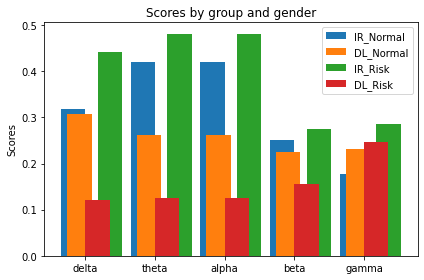

In [33]:
fig, ax = plt.subplots()
Normal_IR = ax.bar(x - width/2, height = IR_plot_normal.mean(), width = width, label = 'IR_Normal')
Normal_DL = ax.bar(x - width/2, height = DL_plot_normal.mean(), width = width, label ='DL_Normal')
Risk_IR = ax.bar(x + width, height = IR_plot_risk.mean(), width = width, label ='IR_Risk')
Risk_DL = ax.bar(x + width/2, height = DL_plot_risk.mean(), width = width, label ='DL_Risk')


ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(bands)
ax.legend()
fig.tight_layout()

plt.show()

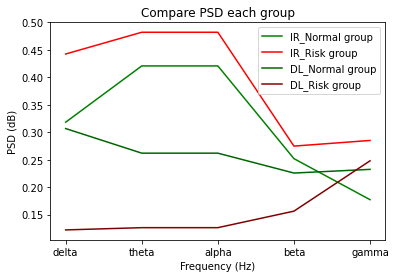

In [32]:
plt.plot(plot_normal_IR.mean(axis = 1), label = 'IR_Normal group', color = 'green')
plt.plot(plot_risk_IR.mean(axis = 1), label = 'IR_Risk group', color = 'red')

plt.plot(plot_normal_DL.mean(axis = 1), label = 'DL_Normal group', color = 'darkgreen')
plt.plot(plot_risk_DL.mean(axis = 1), label = 'DL_Risk group', color = 'maroon')

plt.ylabel('PSD (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('Compare PSD each group')
plt.legend()
#plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/Biomarkers/Compare PSD each group in IR phase.png')

In [123]:
plot_normal_IR

index,F7,F3,FC1,FC5,T7,C3,CP1,CP5,P7,P3,Pz,PO3,O2,PO4,P4,P8,CP6,CP2,C4,T8,FC6,FC2,F4,F8,AF4,Cz
delta,0.588232,0.18183,0.201602,0.196723,0.469048,0.202714,0.24557,0.231906,0.338664,0.301326,0.0353531,0,0.167078,0.0948435,0.188002,1,0.359438,0.18971,0.351927,0.703399,0.597861,0.311366,0.354809,0.434646,0.329294,0.19935
theta,0.923958,0.291918,0.256587,0.368568,0.657597,0.298446,0.301014,0.374056,0.494685,0.399326,0.0477482,0,0.43503,0.111982,0.20383,1,0.44982,0.217678,0.38847,0.864929,0.693697,0.348909,0.411627,0.797712,0.35579,0.246707
alpha,0.923958,0.291918,0.256587,0.368568,0.657597,0.298446,0.301014,0.374056,0.494685,0.399326,0.0477482,0,0.43503,0.111982,0.20383,1,0.44982,0.217678,0.38847,0.864929,0.693697,0.348909,0.411627,0.797712,0.35579,0.246707
beta,0.308964,0.171096,0.187046,0.224372,0.586169,0.176145,0.148507,0.221491,0.244769,0.197186,0.0243271,0,0.0614435,0.0543018,0.164577,1,0.356608,0.15702,0.272882,0.493074,0.316546,0.251932,0.264215,0.235397,0.235145,0.19523
gamma,0.265274,0.0761947,0.0447627,0.256795,1,0.0497303,0.0317245,0.149681,0.21385,0.0389736,0.00739841,0,0.0284867,0.0184083,0.072332,0.899996,0.186825,0.0367066,0.0742009,0.449464,0.182367,0.0523002,0.127557,0.15252,0.150578,0.0380382


# **Inferencial Statistics**

####**Cognitive Markers**

In [0]:
!pip install pingouin

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from scipy import stats
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

* **Mixed ANOVA**


> IR-Total Recall and DL-Total (Within-G) & Group (Between)

In [0]:
df = pd.DataFrame()
df['group'] = pd.concat((CogMarkers['group'], CogMarkers['group']), axis = 0)
df['score'] = pd.concat((CogMarkers['IR-TotalR'],  CogMarkers['DL-TotalR']), 
                        axis = 0)
df['phase'] = None
df.iloc[0:8, 2] = 'IR-TotalR'
df.iloc[8:16, 2] = 'DL-TotalR'

df['group'].replace([0,1], ['Normal', 'Risk'], inplace = True)
df.reset_index(inplace = True)

In [44]:
anv = pg.mixed_anova(data = df, dv = 'score', within = 'phase', between = 'group', subject = 'id')
pg.print_table(anv)


ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc    np2  eps
-----------  ------  -----  -----  ------  -----  -------  -----  -----
group        12.250      1      6  12.250  2.014    0.206  0.251  -
phase         0.250      1      6   0.250  0.333    0.585  0.053  1.0
Interaction   0.250      1      6   0.250  0.333    0.585  0.053  -



In [0]:
posthocs = pg.pairwise_ttests(dv='score', within='phase', between='group',subject='id', data=df)
pg.print_table(posthocs)


POST HOC TESTS

Contrast       phase      A          B          Paired    Parametric         T    dof  Tail         p-unc    BF10    hedges
-------------  ---------  ---------  ---------  --------  ------------  ------  -----  ---------  -------  ------  --------
phase          -          IR-TotalR  DL-TotalR  True      True          -0.607  7.000  two-sided    0.563   0.392    -0.121
group          -          Normal     Risk       False     True           1.419  6.000  two-sided    0.206   0.893     0.873
phase * group  IR-TotalR  Normal     Risk       False     True           1.760  6.000  two-sided    0.129   1.132     1.082
phase * group  DL-TotalR  Normal     Risk       False     True           1.029  6.000  two-sided    0.343   0.706     0.633



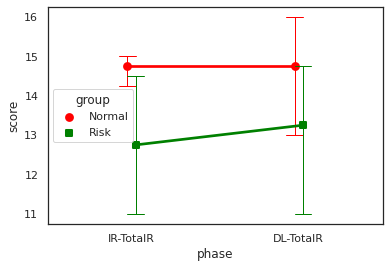

In [0]:
sns.set(style = 'white')
sns.pointplot(data=df, x='phase', y='score', hue='group', dodge=True, markers=['o', 's'],
	      capsize=.1, errwidth=1, palette = ['red','green'], grid = False)



> %IR-FreeR, %IR-CuedR, %DL-FreeR, %DL-CuedR (within) & Group (Between)



In [0]:
cog_m =CogMarkers.copy()
cog_m['IR-FreeR'] = (CogMarkers['IR-FreeR'])/16
cog_m['IR-CuedR'] = (CogMarkers['IR-CuedR'])/(16-CogMarkers['IR-FreeR'])
cog_m['DL-FreeR'] = (CogMarkers['DL-FreeR'])/16
cog_m['DL-CuedR'] = (CogMarkers['DL-CuedR'])/(16-CogMarkers['DL-FreeR'])

cog_m['group'] = pd.Categorical(cog_m['group'])

In [0]:
df = pd.DataFrame()
df['group'] = pd.concat((cog_m['group'], cog_m['group'], cog_m['group'], cog_m['group']), axis = 0)
df['score'] = pd.concat((cog_m['IR-FreeR'],  cog_m['IR-CuedR'], cog_m['DL-FreeR'],  cog_m['DL-CuedR']), 
                        axis = 0)
df['phase'] = None
df.iloc[0:8, 2] = 'IR-FreeR'
df.iloc[8:16, 2] = 'IR-CuedR'
df.iloc[16:24, 2] = 'DL-FreeR'
df.iloc[24:32, 2] = 'DL-CuedR'

df['group'].replace([0,1], ['Normal', 'Risk'], inplace = True)
df.reset_index(inplace = True)

In [0]:
anv = pg.mixed_anova(data = df, dv = 'score', within = 'phase', between = 'group', subject = 'id')
pg.print_table(anv)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2  eps
-----------  -----  -----  -----  -----  ------  -------  -----  -----
group        0.108      1      6  0.108   1.574    0.256  0.208  -
phase        0.331      3     18  0.110  15.685    0.000  0.723  0.858
Interaction  0.060      3     18  0.020   2.841    0.067  0.321  -



In [0]:
posthocs = pg.pairwise_ttests(dv='score', within='group', between='phase',subject='id', data=df)
pg.print_table(posthocs)


POST HOC TESTS

Contrast       group    A         B         Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-------------  -------  --------  --------  --------  ------------  ------  ------  ---------  -------  ------  --------
group          -        Normal    Risk      True      True           2.221  15.000  two-sided    0.042   1.715     0.646
phase          -        IR-FreeR  IR-CuedR  False     True          -2.372  14.000  two-sided    0.033   2.316    -1.121
phase          -        IR-FreeR  DL-FreeR  False     True           0.000  14.000  two-sided    1.000   0.428     0.000
phase          -        IR-FreeR  DL-CuedR  False     True          -2.573  14.000  two-sided    0.022   3.003    -1.216
phase          -        IR-CuedR  DL-FreeR  False     True           2.500  14.000  two-sided    0.025   2.729     1.182
phase          -        IR-CuedR  DL-CuedR  False     True          -0.501  14.000  two-sided    0.624   0.466    -0.237
phase          

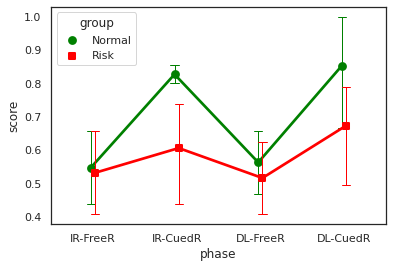

In [0]:
sns.set(style = 'white')
sns.pointplot(data=df, x='phase', y='score', hue='group', dodge=True, markers=['o', 's'],
	      capsize=.1, errwidth=1, palette = ['green','red'], grid = False)

* **Multiple Regression**

In [0]:
reg = pg.linear_regression(X = cog_m[['IR-FreeR','IR-CuedR','DL-FreeR','DL-CuedR','MoCA']], y = cog_m['group'])
pg.print_table(reg)

names        coef     se       T    pval     r2    adj_r2    CI[2.5%]    CI[97.5%]
---------  ------  -----  ------  ------  -----  --------  ----------  -----------
Intercept   1.816  0.835   2.175   0.162  0.856     0.498      -1.776        5.407
IR-FreeR    2.634  1.973   1.335   0.314  0.856     0.498      -5.857       11.125
IR-CuedR   -1.536  1.428  -1.076   0.395  0.856     0.498      -7.680        4.608
DL-FreeR    0.894  1.988   0.450   0.697  0.856     0.498      -7.658        9.445
DL-CuedR   -2.203  1.582  -1.393   0.298  0.856     0.498      -9.009        4.602
MoCA       -0.031  0.025  -1.222   0.346  0.856     0.498      -0.141        0.078



* **Logistic Regression**

In [0]:
X = pd.concat((per_cog_risk[['IR-FreeR','DL-FreeR']], 
               per_cog_normal[['IR-FreeR',	'DL-FreeR']]), axis = 0)
y = pd.concat((per_cog_risk[['group']], 
               per_cog_normal[['group']]), axis = 0)

In [0]:
regressor = LogisticRegression()
regressor.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

* SVM

In [0]:
clf = SVC()
clf.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
plt.figure(1, figsize = (4, 3))
plt.clf()
plt.scatter(X.ravel(), y, color = 'black')

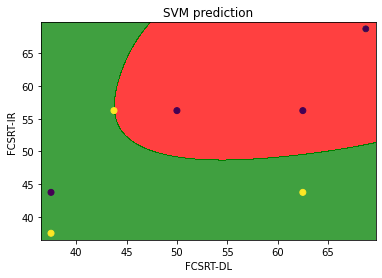

In [0]:
from matplotlib.colors import ListedColormap
X_set, y_set = X, y
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, 
             clf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))

plt.scatter(X_set[:,0], X_set[:,1], c = y)
plt.title('SVM prediction')
plt.xlabel('FCSRT-DL')
plt.ylabel('FCSRT-IR')
plt.show()

* **Multiple Regression**

In [0]:
pg.linear_regression(cog_m['DL-CuedR'], cog_m['DL-FreeR'], cog_m)

####**Biomarkers**